In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
!pip install fredapi
import fredapi as fa
import datetime as dt
!pip install keras-tuner
import keras_tuner as kt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 9.2 MB/s eta 0:00:00


In [2]:
# Input a ticker to initialize the algorithm (default is S&P 500)
ticker = 'SPY'
start_date = '2000-01-01'
prev_data = yf.Ticker(ticker).history(start=start_date, interval='1d') # gather the daily data of the selected stock
prev_data = prev_data[['Close']] # we only want the close price, and the volume

In [3]:
# Gather the US price index and CBOE volatility index	
US_price_index = yf.Ticker('DX-Y.NYB').history(start=start_date, interval='1d')['Close']
VIX = yf.Ticker('^VIX').history(start=start_date, interval='1d')['Close']

In [4]:
# Gather the Interest Rate and Consumer Sentiment Index
fred = fa.Fred(api_key='9d0313b2f492b5cfe3f9276808b6260d')
EFFR = fred.get_series('EFFR')
UMCSENT = fred.get_series('UMCSENT')
EFFR = pd.DataFrame(EFFR)
UMCSENT = pd.DataFrame(UMCSENT)
# Since consumer sentiment index are monthly data, convert it to daily data
start_date = UMCSENT.index.min() - pd.DateOffset(day=1)
end_date = UMCSENT.index.max() + pd.DateOffset(day=31)
dates = pd.date_range(start_date, end_date, freq='D')
dates.name = 'date'
UMCSENT = UMCSENT.reindex(dates, method='ffill')

In [5]:
# We only want data that is on/after the start_date
EFFR = EFFR.loc[EFFR.index >= start_date]
UMCSENT = UMCSENT.loc[UMCSENT.index >= start_date]

In [6]:
# Standarize the index column for concatenation
EFFR.index = [x.date() for x in pd.to_datetime(EFFR.index).tz_localize('Etc/UCT')]
UMCSENT.index = [x.date() for x in pd.to_datetime(UMCSENT.index).tz_localize('Etc/UCT')]
prev_data.index = [x.date() for x in pd.to_datetime(prev_data.index)]
US_price_index.index = [x.date() for x in pd.to_datetime(US_price_index.index)]
VIX.index = [x.date() for x in pd.to_datetime(VIX.index)]

In [7]:
# Cancatenate the dataframes
prev_data = pd.concat([prev_data, US_price_index, VIX, EFFR, UMCSENT], axis=1)
prev_data = prev_data.dropna()
prev_data.columns = ['Close', 'US_Price_Index', 'VIX', 'EFFR', 'UMCSENT']
prev_data.head()

,Close,US_Price_Index,VIX,EFFR,UMCSENT
2000-07-03,96.621445,107.059998,19.830000,7.03,108.3
2000-07-05,94.878845,107.120003,21.160000,6.52,108.3
2000-07-06,95.616875,107.370003,20.940001,6.51,108.3
2000-07-07,97.154488,107.650002,19.219999,6.42,108.3
2000-07-10,96.990433,107.010002,20.330000,6.51,108.3


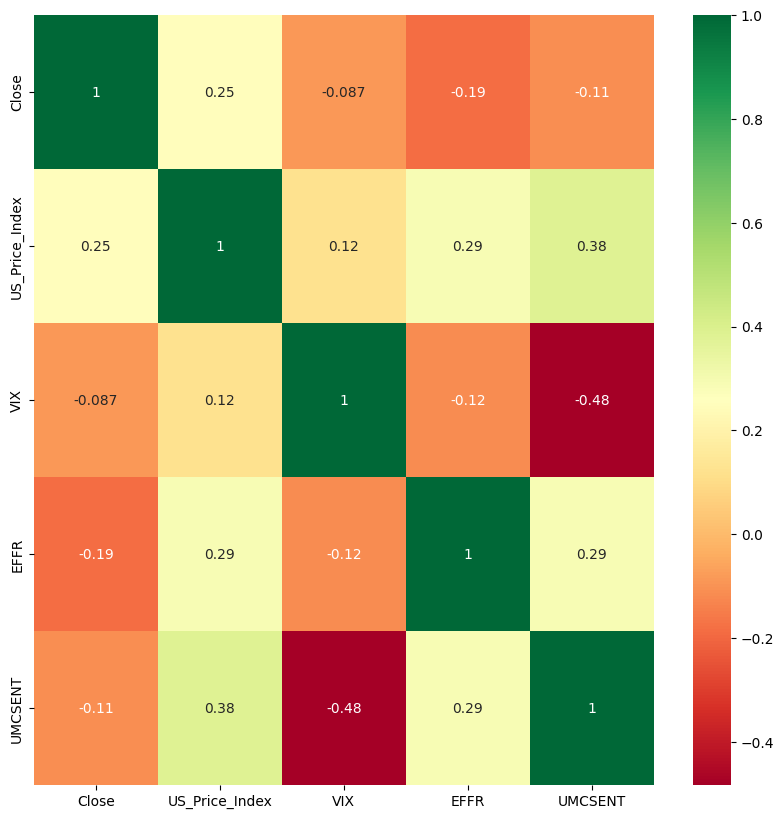

In [8]:
# Validate the relevance of the features using heatmap
# get correlations of each features in dataset
corrmat = prev_data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
# plot heatmap
g=sns.heatmap(prev_data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [9]:
# Convert dataframe to numpy array
prev_data = prev_data.to_numpy()
close_price = prev_data[:,1]

In [10]:
# Use Min-max to normalize the data
scaler = MinMaxScaler()
prev_data = scaler.fit_transform(prev_data)

# Use the previous 30 days' data to predict the next day's stock price
T = 30
predict_len = 1
X = []
Y = []
for t in range(len(prev_data) - T):
  x = prev_data[t:t+T]
  X.append(x)
  y = prev_data[t+T:t+T+predict_len,0]
  Y.append(y)
X = np.array(X)
Y = np.array(Y).flatten()

# confirm the shape
print(X.shape)
print(Y.shape)

(5644, 30, 5)
(5644,)


In [11]:
def build_model(hp):
  model = tf.keras.Sequential()
  # Layer 1: LSTM with rnn_units number of units
  model.add(
      tf.keras.layers.LSTM(
        hp.Int("LSTM_unit", min_value=32, max_value=512, step=32),
        activation=hp.Choice("activation", ["relu", "tanh", "sigmoid"]),
        return_sequences=False,
        batch_input_shape=[1, 30, 5],
      )
  )
        
  # Layer 2: Dropout layer to prevent overfitting
  if hp.Boolean("dropout"):
    model.add(tf.keras.layers.Dropout(0.25))

  # Layer 3: Dense (fully-connected) layer that transforms Dense layer output to the predicted price
  model.add(tf.keras.layers.Dense(1))

  hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 5e-2, 1e-4])
  model.compile(loss='mse', 
                optimizer=tf.keras.optimizers.experimental.Adagrad(learning_rate=hp_learning_rate), 
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
  
  return model

In [12]:
# define the RandomSearch tuner
tuner = kt.RandomSearch(build_model,
                        objective=kt.Objective("val_mean_absolute_error", direction="min"),
                        max_trials=40,
                        executions_per_trial=1,
                        overwrite=True,
                        directory="./kt_dir",
                        project_name="kt_randomSearch",)
tuner.search_space_summary()

Search space summary
Default search space size: 4
LSTM_unit (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.05, 0.0001], 'ordered': True}


In [13]:
# split the train test data (75% for training, 25% for validation)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=11)
# Search for the best hyper parameters
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test))
tuner.results_summary()

Trial 40 Complete [00h 05m 24s]
val_mean_absolute_error: 0.16160498559474945

Best val_mean_absolute_error So Far: 0.004886954091489315
Total elapsed time: 03h 42m 52s
Results summary
Results in ./kt_dir/kt_randomSearch
Showing 10 best trials
Objective(name="val_mean_absolute_error", direction="min")

Trial 16 summary
Hyperparameters:
LSTM_unit: 448
activation: tanh
dropout: False
learning_rate: 0.05
Score: 0.004886954091489315

Trial 19 summary
Hyperparameters:
LSTM_unit: 128
activation: tanh
dropout: True
learning_rate: 0.05
Score: 0.0049750483594834805

Trial 08 summary
Hyperparameters:
LSTM_unit: 192
activation: tanh
dropout: False
learning_rate: 0.05
Score: 0.005197590216994286

Trial 38 summary
Hyperparameters:
LSTM_unit: 384
activation: tanh
dropout: False
learning_rate: 0.01
Score: 0.005768297240138054

Trial 04 summary
Hyperparameters:
LSTM_unit: 512
activation: relu
dropout: True
learning_rate: 0.05
Score: 0.00584438256919384

Trial 32 summary
Hyperparameters:
LSTM_unit: 352


In [14]:
# Get the model with the lowest mean absolute error
models = tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.build()
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 448)                  813568    
                                                                 
 dense (Dense)               (1, 1)                    449       
                                                                 
Total params: 814,017
Trainable params: 814,017
Non-trainable params: 0
_________________________________________________________________


In [15]:
# train the model
r = best_model.fit(
  X_train, y_train,
  epochs=50,
  validation_data=(X_test, y_test),
)

Epoch 1/50
133/133 [==============================] - 29s 202ms/step - loss: 8.4950e-05 - mean_absolute_error: 0.0060 - val_loss: 1.0907e-04 - val_mean_absolute_error: 0.0082
Epoch 2/50
133/133 [==============================] - 27s 202ms/step - loss: 8.1108e-05 - mean_absolute_error: 0.0059 - val_loss: 7.2993e-05 - val_mean_absolute_error: 0.0050
Epoch 3/50
133/133 [==============================] - 27s 203ms/step - loss: 7.7990e-05 - mean_absolute_error: 0.0057 - val_loss: 4.3307e-04 - val_mean_absolute_error: 0.0191
Epoch 4/50
133/133 [==============================] - 28s 214ms/step - loss: 8.3897e-05 - mean_absolute_error: 0.0059 - val_loss: 7.5836e-05 - val_mean_absolute_error: 0.0055
Epoch 5/50
133/133 [==============================] - 29s 217ms/step - loss: 7.9326e-05 - mean_absolute_error: 0.0058 - val_loss: 7.4483e-05 - val_mean_absolute_error: 0.0053
Epoch 6/50
133/133 [==============================] - 27s 203ms/step - loss: 7.2072e-05 - mean_absolute_error: 0.0054 - val_l

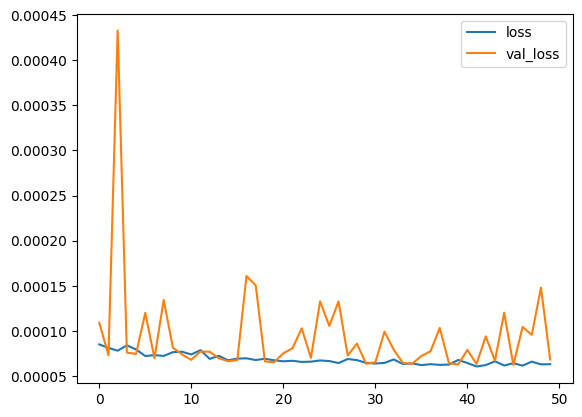

In [16]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

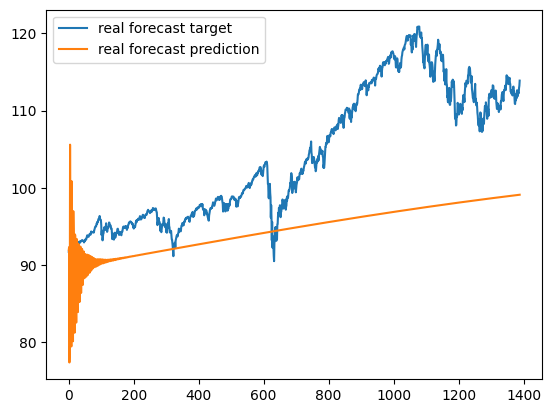

In [17]:
# Multi-step forecast
validation_target = Y[int(len(prev_data) * 0.75):]
validation_predictions = []

# First validation input
last_x = X[int(len(prev_data) * 0.75)] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = best_model.predict(last_x.reshape(1, last_x.shape[0], 5), verbose=0)[0,0] # 1x1 array -> scalar
  
  # Update the predictions list
  validation_predictions.append(p)
  
  # Make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

# Denormalize the outputs to get the real stock prices
real_predictions = np.array(validation_predictions) * (np.amax(close_price) - np.amin(close_price)) + np.amin(close_price)
real_target = validation_target * (np.amax(close_price) - np.amin(close_price)) + np.amin(close_price)
plt.plot(real_target, label='real forecast target')
plt.plot(real_predictions, label='real forecast prediction')
plt.legend()

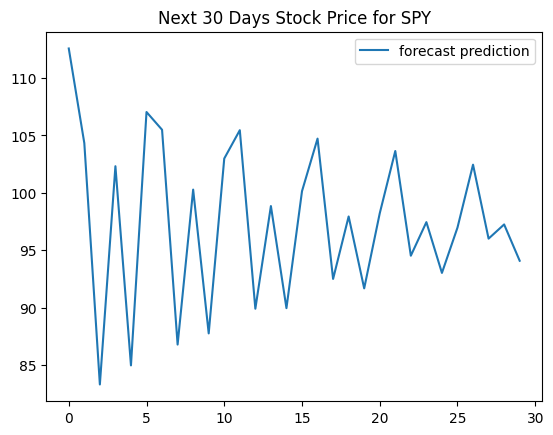

In [19]:
# Multi-step forecast
future_30_predictions = []

# Latest data entry in the dataset
last_x = X[-1] # 1-D array of length T

while len(future_30_predictions) < last_x.shape[0]:
  p = best_model.predict(last_x.reshape(1, last_x.shape[0], 5), verbose = 0)[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  future_30_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

# Denormalize the output to get the real stock prices
real_future_30_predictions = np.array(future_30_predictions) * (np.amax(close_price) - np.amin(close_price)) + np.amin(close_price)
plt.plot(real_future_30_predictions, label='forecast prediction')
plt.title('Next 30 Days Stock Price for ' + ticker)
plt.legend()